In [73]:
import pandas as pd

batting = pd.read_csv("/Users/fool/Downloads/archive/Batting.csv")
fielding = pd.read_csv("/Users/fool/Downloads/archive/Fielding.csv")
master = pd.read_csv("/Users/fool/Downloads/archive/Master.csv", encoding='ISO-8859-1')

batting.fillna(0, inplace=True)

# Aggregate batting by playerID
bat_agg = batting.groupby('playerID').agg({
    'AB': 'sum',
    'H': 'sum',
    'BB': 'sum',
    'SO': 'sum',
    'HR': 'sum',
    '2B': 'sum',
    '3B': 'sum',
    'SF': 'sum'
}).reset_index()

bat_agg['1B'] = bat_agg['H'] - (bat_agg['2B'] + bat_agg['3B'] + bat_agg['HR'])
bat_agg = bat_agg[bat_agg['AB'] > 250]

bat_agg['HR_rate'] = bat_agg['HR'] / bat_agg['AB']
bat_agg['SO_rate'] = bat_agg['SO'] / bat_agg['AB']
bat_agg['BB_rate'] = bat_agg['BB'] / bat_agg['AB']
bat_agg['OBP'] = (bat_agg['H'] + bat_agg['BB']) / (bat_agg['AB'] + bat_agg['BB'] + bat_agg['SF'])
bat_agg['SLG'] = (bat_agg['1B'] + 2 * bat_agg['2B'] + 3 * bat_agg['3B'] + 4 * bat_agg['HR']) / bat_agg['AB']

##final batting features
batting_final = bat_agg[['playerID', 'HR_rate', 'SO_rate', 'BB_rate', 'OBP', 'SLG']]



master_info = master[['playerID', 'weight', 'height', 'bats', 'throws', 'birthCountry']]

# Aggregate fielding
fielding.fillna(0, inplace=True)
fielding['InnOuts'] = fielding['InnOuts'].fillna(0)
fielding_agg = fielding.groupby('playerID').agg({
    'PO': 'sum',
    'A': 'sum',
    'E': 'sum',
    'DP': 'sum',
    'POS': lambda x: x.mode()[0] if not x.mode().empty else 'UNK',  # most common position
    'InnOuts': 'sum'
}).reset_index()

# Merge 
merged = batting_final.merge(master_info, on='playerID', how='left')
merged = merged.merge(fielding_agg, on='playerID', how='left')

print(merged.head())



    playerID   HR_rate   SO_rate   BB_rate       OBP       SLG  weight  \
0  aaronha01  0.061064  0.111857  0.113394  0.372507  0.554513   180.0   
1  aaronto01  0.013771  0.153602  0.091102  0.291506  0.327331   190.0   
2  abbated01  0.003614  0.005256  0.094941  0.318332  0.325230   170.0   
3  abbeych01  0.010851  0.059966  0.095374  0.343587  0.404340   169.0   
4  abbotfr01  0.001949  0.000000  0.037037  0.236842  0.278752   180.0   

   height bats throws birthCountry       PO       A      E     DP POS  \
0    72.0    R      R          USA  12926.0   647.0  259.0  258.0  OF   
1    75.0    R      R          USA   1494.0   117.0   32.0  124.0  1B   
2    71.0    R      R          USA   1872.0  2368.0  315.0  247.0  2B   
3    68.0    L    NaN          USA    917.0    90.0   99.0   18.0  OF   
4    70.0    R      R          USA    768.0   185.0   40.0   26.0  1B   

    InnOuts  
0  150488.0  
1    9346.0  
2       0.0  
3       0.0  
4       0.0  


## Clustering

In [74]:
from sklearn.preprocessing import StandardScaler

# numeric features for clustering
features = merged[['HR_rate', 'SO_rate', 'BB_rate', 'OBP', 'SLG',
                   'weight', 'height', 'PO', 'A', 'E', 'DP', 'InnOuts']].copy()
features = features.fillna(0)

# Standardize 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sa

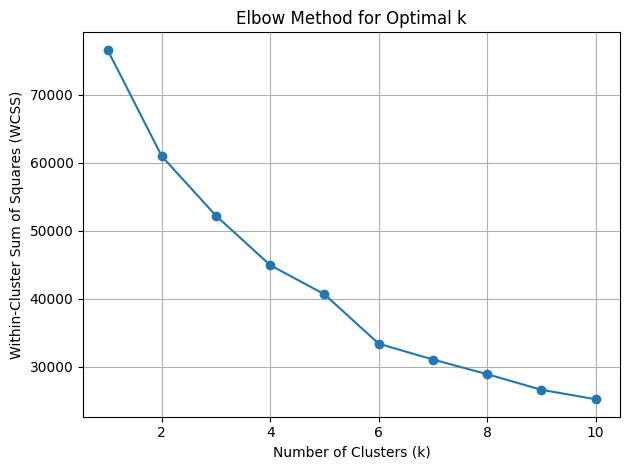

In [75]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.tight_layout()
plt.show()

In [76]:
kmeans = KMeans(n_clusters=5, random_state=42)
merged['cluster'] = kmeans.fit_predict(X_scaled)


/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sa

In [77]:
cluster_profiles = merged.groupby('cluster')[features.columns].mean()
print(cluster_profiles)


          HR_rate   SO_rate   BB_rate       OBP       SLG      weight  \
cluster                                                                 
0        0.034278  0.154535  0.111138  0.345969  0.444931  193.200000   
1        0.004174  0.288566  0.045305  0.193765  0.198615  188.936430   
2        0.013073  0.096759  0.090950  0.327185  0.372637  172.942207   
3        0.026695  0.188696  0.099395  0.318760  0.395131  194.887987   
4        0.005805  0.083871  0.074416  0.297483  0.320723  171.870232   

            height           PO            A           E          DP  \
cluster                                                                
0        73.039623  8448.045283   620.332075  126.784906  421.354717   
1        73.224939   135.825183   312.971883   21.941320   19.754279   
2        70.545455  2966.573427  3563.833916  290.526224  635.599650   
3        72.740801  1693.413420   303.784091   40.860931   75.074675   
4        70.383616   989.321620   443.807487   69.102368

In [79]:
from sklearn.decomposition import PCA

#PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

#dataframe
merged['PC1'] = X_pca[:, 0]
merged['PC2'] = X_pca[:, 1]


plt.figure(figsize=(10, 6))
for label in merged['Archetype'].unique():
    subset = merged[merged['Archetype'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=label, alpha=0.6)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of MLB Player Archetypes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


KeyError: 'Archetype'

<Figure size 1000x600 with 0 Axes>

In [80]:
cluster_labels = {
    0: 'Elite All-Around Starters',
    1: 'Low-Usage Bench Players',
    2: 'Defensive Workhorses',
    3: 'Versatile Role Players',
    4: 'Bench/Speed Players' 
}

merged['Archetype'] = merged['cluster'].map(cluster_labels)


## Prediction

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# drop rows without archetypes 
df = merged.dropna(subset=['Archetype'])

# target labels
le = LabelEncoder()
y = le.fit_transform(df['Archetype'])

feature_cols = ['HR_rate', 'SO_rate', 'BB_rate', 'OBP', 'SLG',
                'weight', 'height', 'PO', 'A', 'E', 'DP', 'InnOuts']
X = df[feature_cols].fillna(0)

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [82]:
from sklearn.linear_model import LogisticRegression

# logistic regression
clf = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
clf.fit(X_train, y_train)


/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/fool/Library/Py

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [83]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict
y_pred = clf.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Confusion Matrix:
[[413  21   5  38  52]
 [  5 116   0   0   0]
 [  1   4  95   0   6]
 [ 25   0   0 133   3]
 [ 88   0   5  18 250]]

Classification Report:
                           precision    recall  f1-score   support

      Bench/Speed Players       0.78      0.78      0.78       529
     Defensive Workhorses       0.82      0.96      0.89       121
Elite All-Around Starters       0.90      0.90      0.90       106
  Low-Usage Bench Players       0.70      0.83      0.76       161
   Versatile Role Players       0.80      0.69      0.74       361

                 accuracy                           0.79      1278
                macro avg       0.80      0.83      0.81      1278
             weighted avg       0.79      0.79      0.79      1278



/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [84]:
import pandas as pd

# Probability
proba = clf.predict_proba(X_test)
proba_df = pd.DataFrame(proba, columns=[f"Prob_{label}" for label in le.classes_])
print(proba_df)


      Prob_Bench/Speed Players  Prob_Defensive Workhorses  \
0                 7.857889e-01               3.850532e-07   
1                 1.713158e-01               1.332892e-07   
2                 1.661425e-01               7.579668e-08   
3                 7.846087e-01               1.872685e-07   
4                 1.957681e-01               7.860810e-08   
...                        ...                        ...   
1273              5.670166e-01               9.588292e-08   
1274              1.802865e-06               9.397157e-08   
1275              1.904853e-01               1.571434e-08   
1276              3.099522e-01               7.573917e-08   
1277              7.315880e-20               3.168834e-07   

      Prob_Elite All-Around Starters  Prob_Low-Usage Bench Players  \
0                       1.985658e-05                  3.229509e-07   
1                       1.812296e-04                  2.387986e-03   
2                       5.297761e-05                  6.9

/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


## Predict Position Using Stats + Archetype


In [85]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# drop missing positions
df_pos = merged.dropna(subset=['POS'])

# encode position as target
pos_encoder = LabelEncoder()
y_pos = pos_encoder.fit_transform(df_pos['POS'])

#
X_pos = df_pos[['HR_rate', 'SO_rate', 'BB_rate', 'OBP', 'SLG',
                'weight', 'height', 'PO', 'A', 'E', 'DP', 'InnOuts']].copy()

#Archetype as categorical input
X_pos['Archetype'] = df_pos['Archetype']
X_pos = pd.get_dummies(X_pos, columns=['Archetype'], drop_first=True)

# Fill missing and split
X_pos = X_pos.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X_pos, y_pos, test_size=0.2, random_state=42)


In [86]:
# Train 
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# predict
y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=pos_encoder.classes_))


[[112   2   1   2   0   0   0   8   3   1   0]
 [  1 110  14   4   0   0   0   6   1   0  18]
 [  1  36  70   1   0   0   0   2   4   0   2]
 [  3   0   0 168   0   0   0  11   0   0   0]
 [  0   3   0   2  22   0   6  20   0   0   0]
 [  3   0   0   0   1   0   0   4   1   0   1]
 [  5   1   1   3   7   0   9  23   0   1   0]
 [  9   6   6  10  12   0  13 197   3   0   0]
 [  2   2   2   0   0   0   0   5 197   0   1]
 [  0   0   0   0   0   0   3   1   0   1   0]
 [  0  40  11   0   0   0   0   2   3   0  58]]
              precision    recall  f1-score   support

          1B       0.82      0.87      0.85       129
          2B       0.55      0.71      0.62       154
          3B       0.67      0.60      0.63       116
           C       0.88      0.92      0.90       182
          CF       0.52      0.42      0.46        53
          DH       0.00      0.00      0.00        10
          LF       0.29      0.18      0.22        50
          OF       0.71      0.77      0.74      

/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/fool/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [59]:
#top features
import pandas as pd
import numpy as np

feature_importance = pd.Series(rf.feature_importances_, index=X_train.columns)
print(feature_importance.sort_values(ascending=False).head(10))


PO         0.158637
A          0.148909
DP         0.136936
OBP        0.087010
SLG        0.073116
E          0.069791
InnOuts    0.066327
SO_rate    0.051859
HR_rate    0.048446
BB_rate    0.043783
dtype: float64
